In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import graphviz
import matplotlib.pyplot as plt
import matplotlib as mlp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn import mixture
import itertools
from scipy import linalg

from sklearn.decomposition import FastICA, PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
rand_state=42

0    16258
1     1639
Name: 0, dtype: int64

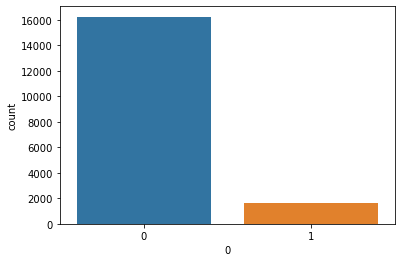

In [8]:
# Dataset source:
# http://archive.ics.uci.edu/ml/datasets/HTRU2#

# Read in data
data = pd.read_csv('../data/HTRU_2.csv', sep=',')
sns.countplot(data.iloc[:,-1]) # plot number of things with each value

data.iloc[:,-1].value_counts(sort=True)

In [9]:
# Create training, testing, and validation sets

X = data.drop(data.columns[-1], axis=1) # last value is the pulsar indicator

y = data.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2) # 80/20

# scale so it converges
scaling = MinMaxScaler()
x_train = scaling.fit_transform(x_train)
x_test = scaling.transform(x_test)

y_train_ori = y_train # for indexing later

enc = OneHotEncoder(categories='auto')
y_train = enc.fit_transform(y_train.values.reshape(-1, 1)).todense()
y_test = enc.transform(y_test.values.reshape(-1, 1)).todense()

clusters = 2  silhouette_score is : 0.6295210201157342
clusters = 3  silhouette_score is : 0.6032987825816034
clusters = 4  silhouette_score is : 0.2744401498494354
clusters = 5  silhouette_score is : 0.31652474778613743
clusters = 6  silhouette_score is : 0.3018543575147029
clusters = 7  silhouette_score is : 0.2971096592161356
clusters = 8  silhouette_score is : 0.2645171285692581
clusters = 9  silhouette_score is : 0.25815930424099404
clusters = 10  silhouette_score is : 0.25812925517407714
clusters = 11  silhouette_score is : 0.23318426615032006
clusters = 12  silhouette_score is : 0.2333546313485575


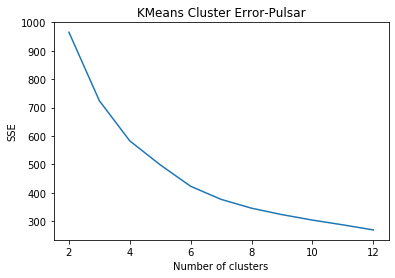

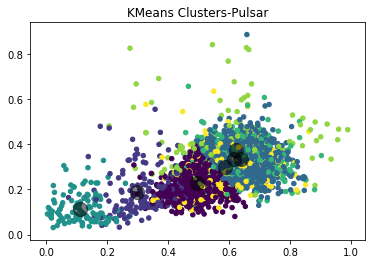

In [15]:
# KMeans
kmeans_opt = kmeans()

BEST GMM
GaussianMixture(n_components=8, random_state=42)


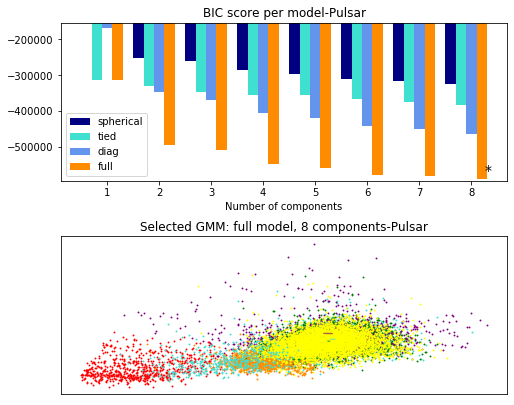

In [16]:
#EM
opt_em = em()

In [14]:
# K-Means
# used https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
def kmeans():
    # EXP 1
    # How to choose the # of clusters
    clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    scores = {'sil': [], 'var': [], 'n_clusters': []}
    centers = {}

    sse = {}
    lowest_bic = np.infty
    bic = []
    from sklearn.metrics import silhouette_score
    for c in clusters:
        kmeans = KMeans(n_clusters=c, random_state=rand_state)
        kmeans.fit(x_train)
        
        # check silouette
        _labels = kmeans.fit_predict(x_train)
        sil_score = silhouette_score(x_train, _labels)
        print("clusters =", c," silhouette_score is :", sil_score)
        
        center = kmeans.cluster_centers_
        centers[c] = center
        sse[c] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    

    # elbow
    #https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.title('KMeans Cluster Error-Pulsar')
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.savefig('../images/' + 'elbow_KM_pulsar.png')
    plt.show()
    
    
    # Visual inspection, 7 appears to be best.
    kmeans_opt = KMeans(n_clusters=7, random_state=rand_state)
    kmeans_opt.fit(x_train)
    y_kmeans_pred=kmeans_opt.predict(x_test)
    # from github above
    plt.scatter(x_test[:, 0], x_test[:, 1], s=20, c=y_kmeans_pred, cmap='viridis')
    centers = kmeans_opt.cluster_centers_
    plt.title('KMeans Clusters-Pulsar')
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    plt.savefig('../images/' + 'KMeans_Clusters_pulsar.png')
    
    # Might not correspond to labels, so testing prediction accuracy not necessarily valid
    return kmeans_opt
    


In [11]:
# Stolen from 
#https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py

def em():
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 9)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    opt_em = None
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type, random_state=42)
            gmm.fit(x_train)
            bic.append(gmm.bic(x_train))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)
    color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                                  'darkorange'])
    opt_em = best_gmm
    print('BEST GMM')
    print(opt_em)
    bars = []

    # Plot the BIC scores
    plt.figure(figsize=(8, 6))
    spl = plt.subplot(2, 1, 1)
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                            width=.2, color=color))
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('BIC score per model-Pulsar')
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
        .2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types)

    # Plot the winner
    splot = plt.subplot(2, 1, 2)
    y_em_pred = opt_em.predict(x_train)
    # more colors for ellipses
    color_iter = itertools.cycle(['yellow', 'turquoise', 'green', 'red', 'purple',
                                  'darkorange'])
    for i, (mean, cov, color) in enumerate(zip(opt_em.means_, opt_em.covariances_,
                                               color_iter)):
        v, w = linalg.eigh(cov)
        if not np.any(y_em_pred == i):
            continue
        plt.scatter(x_train[y_em_pred == i, 0], x_train[y_em_pred == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan2(w[0][1], w[0][0])
        angle = 180. * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mlp.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(.5)
        splot.add_artist(ell)

    plt.xticks(())
    plt.yticks(())
    plt.title('Selected GMM: ' + opt_em.covariance_type + ' model, ' + str(opt_em.n_components) +' components-Pulsar')
    plt.subplots_adjust(hspace=.35, bottom=.02)
    plt.savefig('../images/' + 'best_EM_pulsar.png')
    plt.show()
    return opt_em
    

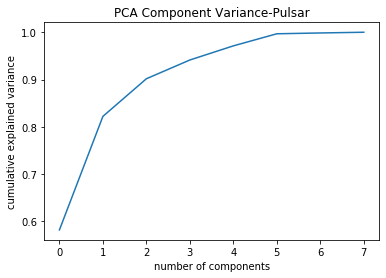

variance
[0.58216716 0.82217276 0.90168076 0.94135009 0.97120251 0.99674829
 0.99847865 1.        ]
original shape:    (14317, 8)
optimal transformed shape: (14317, 4)
LOSS
0.0009001214386546586
LEARNED COMPONENTS
[[-0.29648537 -0.08386983  0.27709879  0.2173708   0.40876051  0.65699198
  -0.37247381 -0.20872979]
 [-0.61148034 -0.3633714   0.42442556  0.32024073 -0.16533878 -0.31874396
   0.23548729  0.16423446]
 [ 0.03004549  0.19374141  0.01544445  0.01899547  0.56629131  0.14922931
   0.49955981  0.6069983 ]
 [-0.35324101  0.83965618  0.16602897 -0.01445504  0.09456414 -0.30075931
  -0.12811162 -0.16313365]]
      140.5625  55.68378214  -0.234571412  -0.699648398  3.199832776  \
PC-1 -0.296485    -0.083870      0.277099      0.217371     0.408761   
PC-2 -0.611480    -0.363371      0.424426      0.320241    -0.165339   
PC-3  0.030045     0.193741      0.015444      0.018995     0.566291   
PC-4 -0.353241     0.839656      0.166029     -0.014455     0.094564   

      19.11042633  7

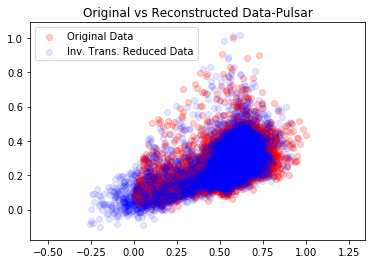

In [18]:
# PCA
#https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

# choosing number of components
pca = PCA(random_state=rand_state).fit(x_train)
x_pca = pca.transform(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA Component Variance-Pulsar')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.savefig('../images/' + 'variance_PCA_pulsar.png')
plt.show()

# so basically, to get 90% of the variance (info), I need to retain 4 components
comps = 4
print('variance')
print(np.cumsum(pca.explained_variance_ratio_))

# how well does it reconstruct data set?
pca_opt = PCA(n_components=comps, random_state=rand_state).fit(x_train)
x_train_pca = pca_opt.transform(x_train)
print("original shape:   ", x_train.shape)
print("optimal transformed shape:", x_train_pca.shape)
X_projected = pca_opt.inverse_transform(x_train_pca)

plt.clf()
# perform the inverse transform of the reduced data and plot it along with the original data:
plt.title('Original vs Reconstructed Data-Pulsar')
plt1 = plt.scatter(x_train[:, 0], x_train[:, 1], color='red', alpha=0.2)
plt2 = plt.scatter(X_projected[:, 0],X_projected[:, 1], color='blue', alpha=0.1)
plt.legend((plt1, plt2), ('Original Data', 'Inv. Trans. Reduced Data'))
plt.axis('equal')
plt.savefig('../images/' + 'ori_recon_data_pulsar.png')



loss = ((x_train - X_projected) ** 2).mean()
print("LOSS")
print(loss)
# learned components
print('LEARNED COMPONENTS')
print(pca_opt.components_)
#TEST
print(pd.DataFrame(pca_opt.components_,columns=X.columns,index = ['PC-1','PC-2', 'PC-3', 'PC-4']))
# Explained variance
print('Explained Variance')
print(pca_opt.explained_variance_)

pca_opt = PCA(n_components=comps, random_state=rand_state)

[3.3295070613489677, 6.533766766170023, 8.99343468351258, 8.485235919638802, 12.190189369886667, 13.953124320681184, 15.447053830211136, 18.488244552817196]


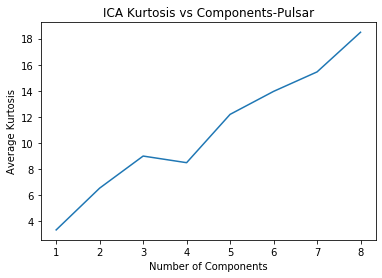

In [19]:
# ICA
# choosing number of components
comps = [1, 2, 3, 4, 5, 6, 7, 8]
kurtosis = []
# based on description in https://piazza.com/class/k51r1vdohil5g3?cid=569
#Calculate the absolute value of kurtosis of each feature
#Take the mean of all these values, and use that as a score for the FastICA algorithm 
# with that number of components
# Pick the number of components that maximizes this score
for comp in comps:
    ica = FastICA(n_components=comp, random_state=rand_state).fit(x_train)
    x_train_ica = ica.transform(x_train)
    kurtosis.append(pd.DataFrame(x_train_ica).kurt().abs().mean())
print(kurtosis)
plt.xlabel('Number of Components')
plt.ylabel('Average Kurtosis')
plt.title('ICA Kurtosis vs Components-Pulsar')
plt.plot(comps, kurtosis)
plt.savefig('../images/' + 'ICA_kurtosis_pulsar.png')
# so no component reduction here. needs all of them?

# No reduction indicated
ica_opt = FastICA(n_components=8, random_state=rand_state)


[0.06979856175662738, 0.06135023496785079, 0.06072441093350665, 0.05047811777149817, 0.04678065836545201, 0.031248571021643325, 0.011421961109980592, 1.0684804698189818e-30]


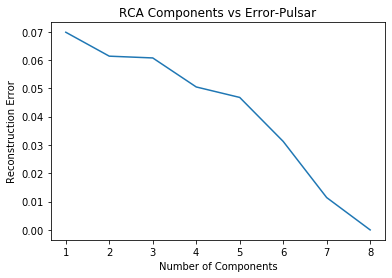

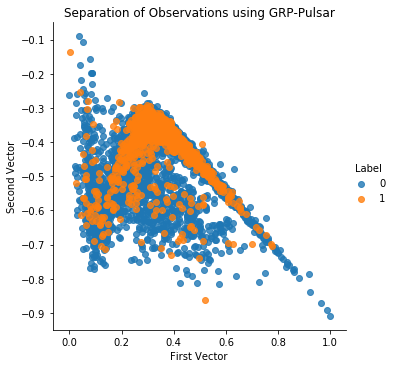

In [20]:
# RCA
# stole from https://www.oreilly.com/library/view/hands-on-unsupervised-learning/9781492035633/ch04.html
# choosing number of components
comps = [1, 2, 3, 4, 5, 6, 7, 8]
error = []
for comp in comps:
    GRP = GaussianRandomProjection(n_components=comp, random_state=rand_state)
    X_train_GRP = GRP.fit_transform(x_train)

    # reconstruction error
    # components
    components = GRP.components_
    # psuedo inverse
    inverse = linalg.pinv(components)
    # reconstructed data - take dot product
    ori_data = ((inverse @ components) @ (x_train.T)).T
    err = np.square(x_train - ori_data)
    av = np.nanmean(err)
    error.append(av)

print(error)
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('RCA Components vs Error-Pulsar')
plt.plot(comps, error)
plt.savefig('../images/' + 'RCA_error_pulsar.png')
    
X_train_GRP = pd.DataFrame(data=X_train_GRP, index=pd.DataFrame(x_train).index)

def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName + '-Pulsar')
    plt.savefig('../images/' + 'RCA_GRP_pulsar.png', bbox_inches='tight')
scatterPlot(X_train_GRP, y_train_ori, "GRP")

# Reducing components to 6
rca_opt = GaussianRandomProjection(n_components=6, random_state=rand_state)


Feature ranking:
1. feature 2 (0.364276)
2. feature 3 (0.205580)
3. feature 0 (0.161556)
4. feature 4 (0.067604)
5. feature 5 (0.065511)
6. feature 1 (0.047852)
7. feature 7 (0.047768)
8. feature 6 (0.039853)
Keep
[2, 3, 0, 4, 5, 1]
Remove
[7, 6]


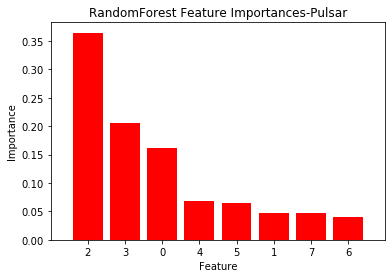

In [21]:
# My Choice-RandomForest
#https://datascience.stackexchange.com/questions/6683/feature-selection-using-feature-importances-in-random-forests-with-scikit-learn
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
clf = RandomForestClassifier(random_state=rand_state)
clf.fit(x_train, y_train)

#feat_import =  x_train[:,clf.feature_importances_.argsort()[::-1][:9]]
feat_import = clf.feature_importances_
std = np.std([clf.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(feat_import)[::-1]

# Print the feature ranking
print("Feature ranking:")

feat_sum = 0
feat_kept_indices = []
feat_removed_indices = []
for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], feat_import[indices[f]]))
    # just adding feature indices to a list until I hit at least 90% retention
    if feat_sum < .90:
        feat_sum += feat_import[indices[f]]
        feat_kept_indices.append(indices[f])
    else:
        feat_removed_indices.append(indices[f])
print('Keep')
print(feat_kept_indices)
print('Remove')
print(feat_removed_indices)
# Plot the feature importances of the forest
plt.figure()
plt.title("RandomForest Feature Importances-Pulsar")
plt.bar(range(x_train.shape[1]), feat_import[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.savefig('../images/' + 'RF_feat_import_pulsar.png')
plt.show()




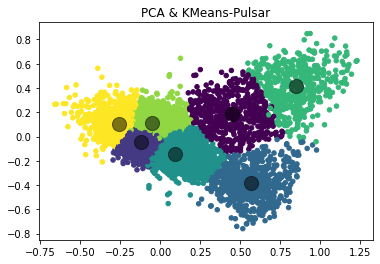

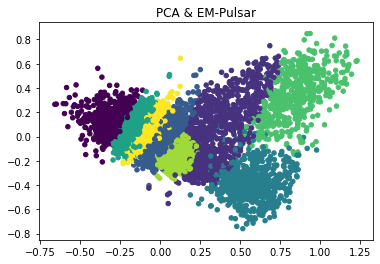

In [22]:
# PCA + KMeans - Run PCA first (above), then KMeans
# pca_opt 'optimal' from above
pca_opt.fit(x_train)
x_train_pca = pca_opt.transform(x_train)

# Visual inspection, 7 appears to be best.
kmeans_pca_opt = KMeans(n_clusters=7, random_state=rand_state)
kmeans_pca_opt.fit(x_train_pca)
y_kmeans_pred=kmeans_pca_opt.predict(x_train_pca)

plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], s=20, c=y_kmeans_pred, cmap='viridis')
centers = kmeans_pca_opt.cluster_centers_
plt.title('PCA & KMeans-Pulsar')

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.savefig('../images/' + 'pca_kmeans_pulsar.png')
plt.show()
# Might not correspond to labels, so testing prediction accuracy not necessarily valid

plt.clf()
# PCA + EM
# opt_em 'optimal' from above
opt_em.fit(x_train_pca)
y_em_pred=opt_em.predict(x_train_pca)

plt.title("PCA & EM-Pulsar")
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], s=20, c=y_em_pred, cmap='viridis')
plt.savefig('../images/' + 'pca_em_pulsar.png')

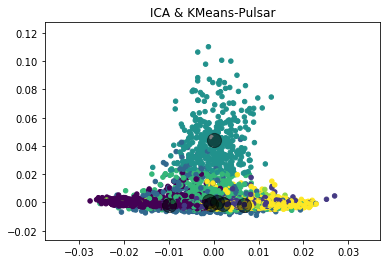

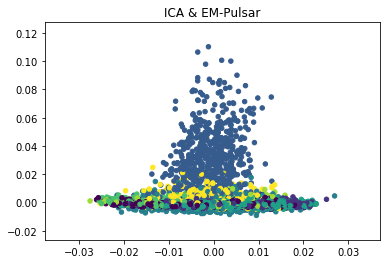

In [23]:
# ICA + KMeans - Run ICA first, then KMeans
# ica_opt 'optimal' from above
# ICA + EM

ica_opt.fit(x_train)
x_train_ica = ica_opt.transform(x_train)

# Visual inspection, 7 appears to be best.
kmeans_ica_opt = KMeans(n_clusters=7, random_state=rand_state)
kmeans_ica_opt.fit(x_train_ica)
y_kmeans_pred=kmeans_ica_opt.predict(x_train_ica)

plt.scatter(x_train_ica[:, 0], x_train_ica[:, 1], s=20, c=y_kmeans_pred, cmap='viridis')
centers = kmeans_ica_opt.cluster_centers_
plt.title('ICA & KMeans-Pulsar')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.savefig('../images/' + 'ica_kmeans_pulsar.png')
plt.show()
# Might not correspond to labels, so testing prediction accuracy not necessarily valid

plt.clf()
# ICA + EM
# opt_em 'optimal' from above
opt_em.fit(x_train_ica)
y_em_pred=opt_em.predict(x_train_ica)

plt.title("ICA & EM-Pulsar")
plt.scatter(x_train_ica[:, 0], x_train_ica[:, 1], s=20, c=y_em_pred, cmap='viridis')
plt.savefig('../images/' + 'ica_em_pulsar.png')

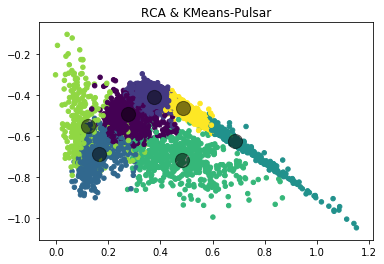

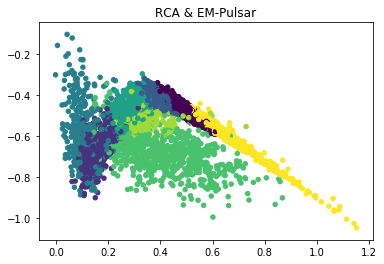

In [24]:
# RCA + KMeans - Run RCA first, then KMeans
#rca_opt 'optimal' from above
# RCA + EM
rca_opt.fit(x_train)
x_train_rca = rca_opt.transform(x_train)

# Visual inspection, 7 appears to be best.
kmeans_rca_opt = KMeans(n_clusters=7, random_state=rand_state)
kmeans_rca_opt.fit(x_train_rca)
y_kmeans_pred=kmeans_rca_opt.predict(x_train_rca)

plt.scatter(x_train_rca[:, 0], x_train_rca[:, 1], s=20, c=y_kmeans_pred, cmap='viridis')
centers = kmeans_rca_opt.cluster_centers_
plt.title('RCA & KMeans-Pulsar')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.savefig('../images/' + 'rca_kmeans_pulsar.png')
plt.show()
# Might not correspond to labels, so testing prediction accuracy not necessarily valid

plt.clf()
# RCA + EM
# opt_em 'optimal' from above
opt_em.fit(x_train_rca)
y_em_pred=opt_em.predict(x_train_rca)

plt.title("RCA & EM-Pulsar")
plt.scatter(x_train_rca[:, 0], x_train_rca[:, 1], s=20, c=y_em_pred, cmap='viridis')
plt.savefig('../images/' + 'rca_em_pulsar.png')

[[7.29078667e-01 3.89247295e-01 1.59644949e-01 ... 3.40890985e-01
  1.66305549e-01 8.98782683e-03]
 [6.91480908e-01 2.94120237e-01 1.91734681e-01 ... 2.13663244e-01
  2.42804378e-01 3.32124551e-02]
 [5.14700347e-01 3.17197380e-01 2.26807303e-01 ... 2.24702472e-01
  2.38524441e-01 3.05057209e-02]
 ...
 [6.22098616e-01 3.59978476e-01 1.91659516e-01 ... 1.41861120e-01
  2.85066396e-01 5.34562526e-02]
 [5.95416336e-01 5.96485893e-01 1.89127957e-01 ... 8.60285773e-01
  1.00109926e-01 4.72506386e-04]
 [6.17707331e-01 2.29838635e-01 2.14772366e-01 ... 1.55215490e-01
  2.60324316e-01 4.30398672e-02]]
(14317, 8)
[[0.72907867 0.38924729 0.15964495 0.01998631 0.0595305  0.34089099]
 [0.69148091 0.29412024 0.19173468 0.02238705 0.02302545 0.21366324]
 [0.51470035 0.31719738 0.2268073  0.02756778 0.02381595 0.22470247]
 ...
 [0.62209862 0.35997848 0.19165952 0.01963606 0.01390668 0.14186112]
 [0.59541634 0.59648589 0.18912796 0.00642881 0.32874398 0.86028577]
 [0.61770733 0.22983863 0.21477237 0.02

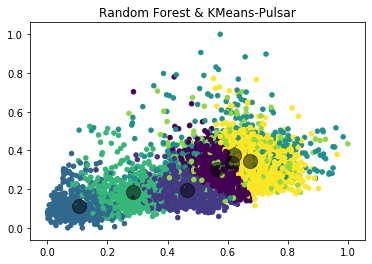

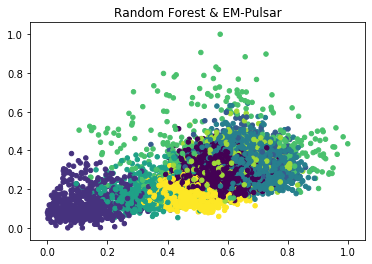

In [25]:
# RandomForest + KMeans - Run RandomForest First, then KMeans
# feat_kept_indices represents the indices kept by RF.
# feat_removed_indices represents features discarded by RF
# RandomForest + EM
#feat_kept_indices = sorted(feat_kept_indices)
feat_removed_indices = sorted(feat_removed_indices)
print(x_train)
print(x_train.shape)

x_train_rfc = np.delete(x_train, obj=feat_removed_indices, axis=1)
print(x_train_rfc)
print(x_train_rfc.shape)

# Visual inspection, 7 appears to be best.
kmeans_rfc_opt = KMeans(n_clusters=7, random_state=rand_state)
kmeans_rfc_opt.fit(x_train_rfc)
y_kmeans_pred=kmeans_rfc_opt.predict(x_train_rfc)

plt.scatter(x_train_rfc[:, 0], x_train_rfc[:, 1], s=20, c=y_kmeans_pred, cmap='viridis')
centers = kmeans_rfc_opt.cluster_centers_
plt.title('Random Forest & KMeans-Pulsar')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.savefig('../images/' + 'rfc_kmeans_pulsar.png')
plt.show()
# Might not correspond to labels, so testing prediction accuracy not necessarily valid

plt.clf()
# RFC + EM
# opt_em 'optimal' from above
opt_em.fit(x_train_rfc)
y_em_pred=opt_em.predict(x_train_rfc)

plt.title("Random Forest & EM-Pulsar")
plt.scatter(x_train_rfc[:, 0], x_train_rfc[:, 1], s=20, c=y_em_pred, cmap='viridis')
plt.savefig('../images/' + 'rfc_em_pulsar.png')

Model: f1=0.860 auc=0.903


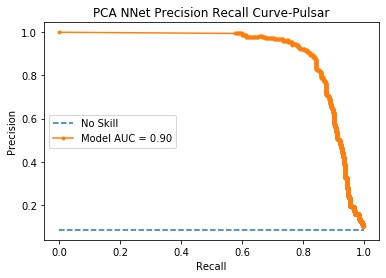

PCA + NN Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3277
           1       0.88      0.84      0.86       303

   micro avg       0.98      0.98      0.98      3580
   macro avg       0.93      0.91      0.92      3580
weighted avg       0.98      0.98      0.98      3580
 samples avg       0.98      0.98      0.98      3580

Model: f1=0.881 auc=0.910


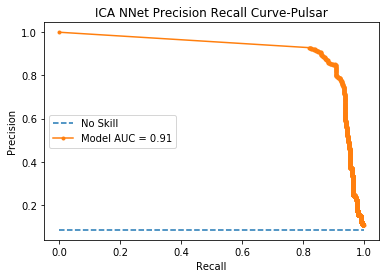

ICA + NN Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3277
           1       0.91      0.86      0.88       303

   micro avg       0.98      0.98      0.98      3580
   macro avg       0.95      0.92      0.94      3580
weighted avg       0.98      0.98      0.98      3580
 samples avg       0.98      0.98      0.98      3580

Model: f1=0.795 auc=0.860


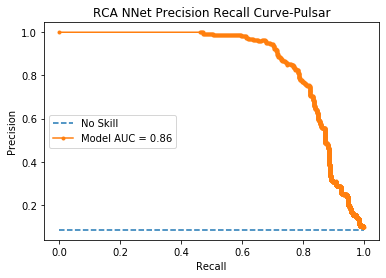

RCA + NN Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3277
           1       0.87      0.73      0.80       303

   micro avg       0.97      0.97      0.97      3580
   macro avg       0.92      0.86      0.89      3580
weighted avg       0.97      0.97      0.97      3580
 samples avg       0.97      0.97      0.97      3580

(14317, 8)
(14317, 6)
Model: f1=0.000 auc=0.105


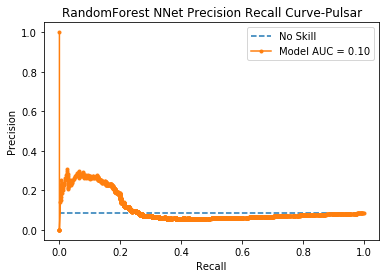

RF + NN Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3277
           1       1.00      0.00      0.00       303

   micro avg       0.92      0.92      0.92      3580
   macro avg       0.96      0.50      0.48      3580
weighted avg       0.92      0.92      0.87      3580
 samples avg       0.92      0.92      0.92      3580



In [51]:
# For this data set only, all of the dim reduction algo (already done above), then NNet
# original NNet from supervised learning optimizations
mlp = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(5, 5, 5, 5, 5, 5), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=20, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

# PCA + NN
# pca_opt 'optimal' from above
pca_opt.fit(x_train)
x_train_pca = pca_opt.transform(x_train)
# Fit the best algorithm to the data. 
mlp.fit(x_train_pca, y_train)
x_test_pca = pca_opt.transform(x_test)
y_predict = mlp.predict(x_test_pca)

plot_precision_recall_curve(mlp, x_test_pca, pd.DataFrame(y_test).values.argmax(axis=1), 
                            y_predict.argmax(axis=1), 'PCA NNet Precision Recall Curve-Pulsar')

# how did we do? Comparing y_test and predicted values
print('PCA + NN Classification Report')
print(classification_report(y_test, y_predict,zero_division=1))

# ICA + NN
ica_opt.fit(x_train)
x_train_ica = ica_opt.transform(x_train)
# Fit the best algorithm to the data. 
mlp.fit(x_train_ica, y_train)
x_test_ica = ica_opt.transform(x_test)
y_predict = mlp.predict(x_test_ica)

plot_precision_recall_curve(mlp, x_test_ica, pd.DataFrame(y_test).values.argmax(axis=1), 
                            y_predict.argmax(axis=1), 'ICA NNet Precision Recall Curve-Pulsar')

print('ICA + NN Classification Report')
print(classification_report(y_test, y_predict,zero_division=1))

# RCA + NN
rca_opt.fit(x_train)
x_train_rca = rca_opt.transform(x_train)
# Fit the best algorithm to the data. 
mlp.fit(x_train_rca, y_train)
x_test_rca = rca_opt.transform(x_test)
y_predict = mlp.predict(x_test_rca)

plot_precision_recall_curve(mlp, x_test_rca, pd.DataFrame(y_test).values.argmax(axis=1), 
                            y_predict.argmax(axis=1), 'RCA NNet Precision Recall Curve-Pulsar')

print('RCA + NN Classification Report')
print(classification_report(y_test, y_predict,zero_division=1))

# RF + NN
#feat_kept_indices = sorted(feat_kept_indices)
feat_removed_indices = sorted(feat_removed_indices)
print(x_train.shape)
x_train_rfc = np.delete(x_train, obj=feat_removed_indices, axis=1)
print(x_train_rfc.shape)
# Fit the best algorithm to the data. 
mlp.fit(x_train_rfc, y_train)
# Need to remove features from test data too
x_test_rfc = np.delete(x_test, obj=feat_removed_indices, axis=1)
y_predict = mlp.predict(x_test_rfc)

plot_precision_recall_curve(mlp, x_test_rfc, pd.DataFrame(y_test).values.argmax(axis=1), 
                            y_predict.argmax(axis=1), 'RandomForest NNet Precision Recall Curve-Pulsar')

print('RF + NN Classification Report')
print(classification_report(y_test, y_predict,zero_division=1))


[0 1 2 3 4 5 6]
KM + NN Training time: 3.0257723331451416s
Model: f1=0.000 auc=0.465


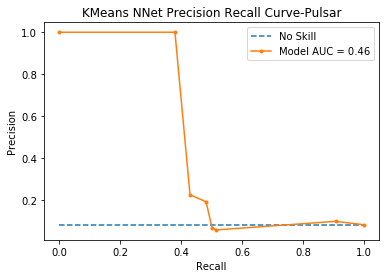

KMeans + NN Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3277
           1       1.00      0.00      0.00       303

   micro avg       0.92      0.92      0.92      3580
   macro avg       0.96      0.50      0.48      3580
weighted avg       0.92      0.92      0.87      3580
 samples avg       0.92      0.92      0.92      3580

EM + NN Training time: 0.9925642013549805s
[0 1 2 3 4 5 6 7]
Model: f1=0.000 auc=0.298


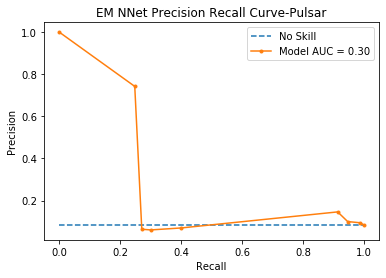

EM + NN Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3277
           1       1.00      0.00      0.00       303

   micro avg       0.92      0.92      0.92      3580
   macro avg       0.96      0.50      0.48      3580
weighted avg       0.92      0.92      0.87      3580
 samples avg       0.92      0.92      0.92      3580



In [54]:
# For this data set only, run clustering, then NNet. Clusters should be form of reduction
# KMeans + NN

import time

kmeans_opt.fit(x_train)
# get training cluster labels
kmeans_train_labels = kmeans_opt.predict(x_train)
kmeans_train_labels = kmeans_train_labels.reshape(-1, 1)
print(np.unique(kmeans_train_labels))
start = time.time()
mlp.fit(kmeans_train_labels, y_train)
stop = time.time()
print(f"KM + NN Training time: {stop - start}s")
# I think I have to do the same thing with the test labels-reduce to cluster label
kmeans_test_labels = kmeans_opt.predict(x_test)
kmeans_test_labels = kmeans_test_labels.reshape(-1, 1)

y_predict = mlp.predict(kmeans_test_labels)

plot_precision_recall_curve(mlp, kmeans_test_labels, pd.DataFrame(y_test).values.argmax(axis=1), 
                            y_predict.argmax(axis=1), 'KMeans NNet Precision Recall Curve-Pulsar')

print('KMeans + NN Classification Report')
print(classification_report(y_test, y_predict,zero_division=1))

# EM + NN
start = time.time()
opt_em.fit(x_train)
stop = time.time()
print(f"EM + NN Training time: {stop - start}s")
em_train_labels = opt_em.predict(x_train)
print(np.unique(em_train_labels))
em_train_labels = em_train_labels.reshape(-1, 1)

mlp.fit(em_train_labels, y_train)
em_test_labels = opt_em.predict(x_test)
em_test_labels = em_test_labels.reshape(-1, 1)

y_predict = mlp.predict(em_test_labels)

plot_precision_recall_curve(mlp, em_test_labels, pd.DataFrame(y_test).values.argmax(axis=1), 
                            y_predict.argmax(axis=1), 'EM NNet Precision Recall Curve-Pulsar')

print('EM + NN Classification Report')
print(classification_report(y_test, y_predict,zero_division=1))

In [45]:
# Precision Recall Curve - works better than ROC for imbalanced sets
# Taken from: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
from sklearn.metrics import precision_recall_curve, f1_score, auc
def plot_precision_recall_curve(model, x_test, y_test, y_predict, title):
    # keep probabilities for the positive outcome only
    model_probs = model.predict_proba(x_test)
    # keep probabilities for the positive outcome only
    model_probs = model_probs[:, 1]

    # predict class values
    #yhat = model.predict(testX)
    # calculate precision and recall for each threshold
    model_precision, model_recall, _ = precision_recall_curve(y_test, model_probs)
    # calculate scores
    model_f1, model_auc = f1_score(y_test, y_predict), auc(model_recall, model_precision)
    # summarize scores
    print('Model: f1=%.3f auc=%.3f' % (model_f1, model_auc))
    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(model_recall, model_precision, marker='.', label='Model AUC = %0.2f' % model_auc)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.savefig('../images/' + title.replace(' ','') + '.png')
    plt.show()